In [706]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import laplace, gaussian_kde
import scipy.cluster.hierarchy as hierarchy
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

In [771]:
#df = pd.read_csv("/Users/albert/git/RTLib/Alignments/FP17_20180520_2/ev_combined.txt", sep="\t", low_memory=False)
df = pd.read_csv("/Users/albert/git/RTLib/Alignments/SQC67-87_20180531_2/ev_updated.txt", sep="\t", low_memory=False)

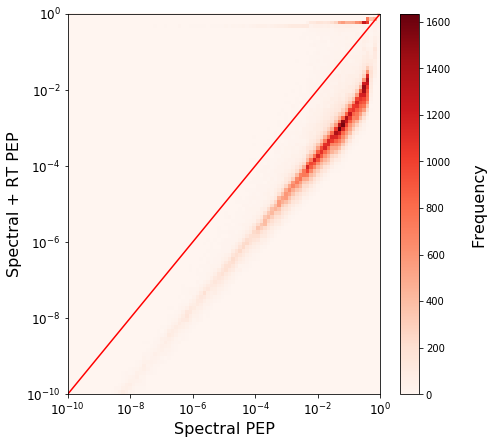

In [773]:
# PEP vs. PEP.new scatterplot
inds = (~pd.isnull(df["pep_new"])) & (df["pep_new"] > 1e-10) & (df["PEP"] > 1e-10)

f, ax = plt.subplots()
hst = ax.hist2d(np.log10(df["PEP"][inds]), np.log10(df["pep_new"][inds]), bins=(100, 100), cmap=plt.cm.Reds)
ax.plot([-10, 0], [-10, 0], '-r')

interval = (-10, 0)
ax.set_xlim(interval)
ax.set_ylim(interval)
ax.set_xlabel("Spectral PEP", fontsize=16)
ax.set_ylabel("Spectral + RT PEP", fontsize=16)
interval = np.arange(-10, 1, 2)
ax.set_xticks(interval)
ax.set_yticks(interval)
ax.set_xticklabels(["$10^{{{}}}$".format(i) for i in interval], fontsize=12)
ax.set_yticklabels(["$10^{{{}}}$".format(i) for i in interval], fontsize=12)

f.set_size_inches(7, 7)

cbar = plt.colorbar(hst[3], ax=ax)
cbar.set_label("Frequency", fontsize=16, labelpad=20, ha="center", va="top")
cbar.ax.xaxis.set_label_position("top")

plt.show()

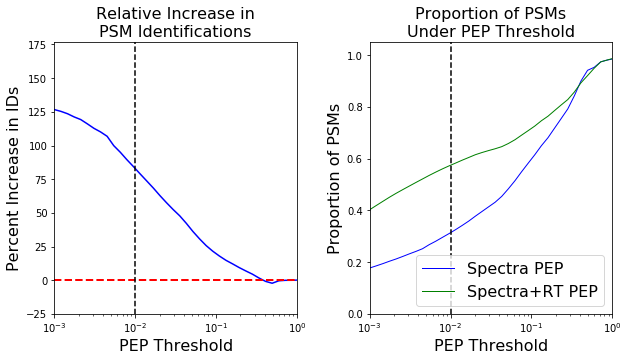

In [778]:
# Fold-change increase
num_points=50
x = np.logspace(-3, 1, num=num_points)
y = np.zeros(num_points)
y2 = np.zeros(num_points)
y3 = np.zeros(num_points)
inds = ~pd.isnull(df["pep_new"])

for i, j in enumerate(x):
    y[i] = np.sum(df["pep_updated"] < j) / np.sum(df["PEP"] < j)
    y2[i] = np.sum(df["PEP"] < j) / df.shape[0]
    y3[i] = np.sum(df["pep_updated"] < j) / df.shape[0]

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.semilogx(x, (y*100)-100, "-b")
ax1.plot([np.min(x), np.max(x)], [0, 0], "-r", linestyle="dashed", linewidth=2)
ax1.plot([1e-2, 1e-2], [-1000, 1000], '-k', linestyle="dashed")
ax1.set_xlim([1e-3, 1])
ax1.set_ylim([-25, np.max(y)*100-50])
ax1.set_xlabel("PEP Threshold", fontsize=16)
ax1.set_ylabel("Percent Increase in IDs", fontsize=16)
ax1.set_title("Relative Increase in\nPSM Identifications", fontsize=16)

ax2.semilogx(x, y2, '-b', linewidth=1, label="Spectra PEP")
ax2.semilogx(x, y3, '-g', linewidth=1, label="Spectra+RT PEP")
#ax2.fill_between(x, 0, y2)
ax2.plot([1e-2, 1e-2], [-1000, 1000], '-k', linestyle="dashed")
ax2.set_xlim([1e-3, 1])
ax2.set_ylim([0, 1.05])
ax2.set_xlabel("PEP Threshold", fontsize=16)
ax2.set_ylabel("Proportion of PSMs", fontsize=16)
ax2.set_title("Proportion of PSMs\nUnder PEP Threshold", fontsize=16)
ax2.legend(fontsize=16)
plt.subplots_adjust(hspace=0.6, wspace=0.3)

f.set_size_inches(10, 5)

plt.show()

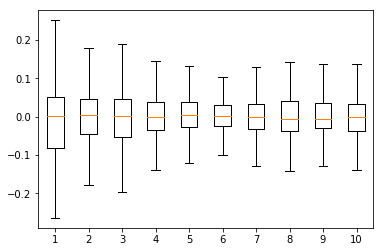

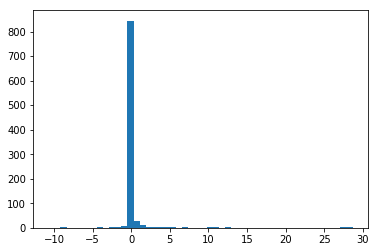

In [204]:
#residual = df["muij"] - df["Retention time"]
#plt.hist(residual[~pd.isnull(residual)], bins=50)
#plt.show()


residual = df["muij"] - df["Retention time"]

sds = df.groupby("exp_id")["residual"].apply((lambda x: np.nanstd(x)))

outliers = np.abs(residual) > (sds.values[df["exp_id"]] * 1)

#residual = np.log(np.abs(residual))

res = [residual[(df["exp_id"]==i) & (~pd.isnull(df["residual"])) & (~outliers)].values for i in range(0, np.max(df["exp_id"]))]
f, ax = plt.subplots()
#ax.violinplot(res)
ax.boxplot(res, showfliers=False)
plt.show()

np.nanstd(np.abs(residual.loc[df["exp_id"]==0]))

plt.hist(residual[(df["exp_id"]==10) & (~pd.isnull(residual))], bins=50)
plt.show()


In [400]:
prots = df["Leading razor protein"]
prots = prots.loc[(~prots.str.contains("REV__")) & (~prots.str.contains("CON__"))]
prots.reset_index(drop=True)

prot_list = prots.value_counts()
prot_list = prot_list.loc[prot_list > 50]

pep_thresh = 0.05

cvs = np.zeros((len(prot_list), 3))
n_cvs = np.zeros((len(prot_list), 3))

for i, j in enumerate(prot_list):
    prot_name = prot_list.index[i]
    intensities = df["Intensity"][(df["Leading razor protein"] == prot_name) & 
                                  (~pd.isnull(df["Intensity"])) & 
                                  (df["PEP"] < pep_thresh)]
    cvs[i][0] = np.std(intensities) / np.mean(intensities)
    n_cvs[i][0] = len(intensities)
    
    intensities = df["Intensity"][(df["Leading razor protein"] == prot_name) & 
                                  (~pd.isnull(df["Intensity"])) & 
                                  (df["pep_new"] < pep_thresh) &
                                  (df["PEP"] > pep_thresh)]
    cvs[i][1] = np.std(intensities) / np.mean(intensities)
    n_cvs[i][1] = len(intensities)
    
    dfa = df.loc[(~pd.isnull(df["Intensity"])) & 
                 (df["PEP"] < pep_thresh) &
                 (~df["Leading razor protein"].str.contains("REV__")) & 
                 (~df["Leading razor protein"].str.contains("CON__"))
                ].sample(n=j)
    cvs[i][2] = np.std(dfa["Intensity"]) / np.mean(dfa["Intensity"])
    n_cvs[i][2] = dfa.shape[0]

# remove pairs which have NAs in them
na_rows = np.apply_along_axis((lambda x: np.isnan(x).any()), 1, cvs)
na_rows = na_rows | (np.apply_along_axis((lambda x: (x == 1).any()), 1, n_cvs))
cvs = cvs[~na_rows]
n_cvs = n_cvs[~na_rows]


In [401]:
n_cvs

array([[202.,  80., 337.],
       [243.,   9., 260.],
       [189.,  36., 253.],
       [195.,  25., 238.],
       [124.,  30., 193.],
       [101.,  33., 143.],
       [107.,  12., 140.],
       [118.,   4., 134.],
       [ 84.,  24., 122.],
       [ 92.,  14., 117.],
       [ 80.,   9., 115.],
       [ 61.,  29., 112.],
       [ 76.,  22., 112.],
       [ 69.,  24.,  98.],
       [ 62.,  11.,  94.],
       [ 68.,  10.,  87.],
       [ 49.,   3.,  86.],
       [ 53.,  21.,  82.],
       [ 41.,   6.,  82.],
       [ 54.,  12.,  81.],
       [ 66.,   8.,  79.],
       [ 33.,  25.,  74.],
       [ 20.,  32.,  73.],
       [ 50.,   8.,  71.],
       [ 44.,  12.,  69.],
       [ 62.,   2.,  69.],
       [ 63.,   4.,  69.],
       [ 58.,   4.,  69.],
       [ 31.,  31.,  69.],
       [ 49.,  17.,  68.],
       [ 42.,  14.,  64.],
       [ 36.,   9.,  64.],
       [ 14.,  34.,  62.],
       [ 43.,  13.,  61.],
       [ 39.,  10.,  58.],
       [ 41.,  12.,  54.],
       [ 29.,  13.,  53.],
 

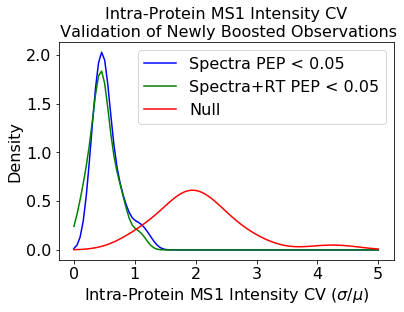

In [403]:
#plt.plot(cvs, null_cvs, '.k')
#plt.plot([0, 10], [0, 10], '-r')
#plt.show()

x = np.linspace(0, 5, 100)
cvs_density = gaussian_kde(cvs[:,0])
new_cvs_density = gaussian_kde(cvs[:,1])
null_cvs_density = gaussian_kde(cvs[:,2])

f, ax = plt.subplots()

ax.plot(x, cvs_density(x), '-b', label="Spectra PEP < {}".format(pep_thresh))
ax.plot(x, new_cvs_density(x), '-g', label="Spectra+RT PEP < {}".format(pep_thresh))
ax.plot(x, null_cvs_density(x), '-r', label="Null")
ax.set_xlabel("Intra-Protein MS1 Intensity CV ($\sigma$/$\mu$)", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
ax.set_title("Intra-Protein MS1 Intensity CV\n Validation of Newly Boosted Observations", fontsize=16)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16)

plt.show()

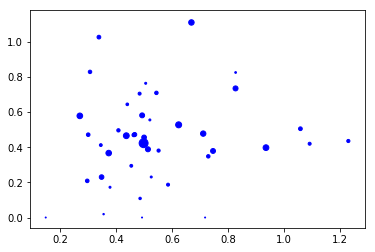

In [388]:
f, ax = plt.subplots()
ax.scatter(cvs[:,0], cvs[:,1], marker="o", color="b", s=n_cvs[:,1])

plt.show()

In [779]:
pep_thresh = 0.5
dcols = df.columns[df.columns.str.contains("Reporter intensity corrected")]
dfa = df.loc[~((df["Leading razor protein"].str.contains("CON__")) | (df["Leading razor protein"].str.contains("REV__")))]
dfa = dfa.loc[dfa["PEP"] < pep_thresh]

prot_dat = dfa.groupby("Leading razor protein")[dcols].apply((lambda x: (x != 0).apply(np.sum, axis=0) / x.shape[0]))
prot_dat

,Reporter intensity corrected 0,Reporter intensity corrected 1,Reporter intensity corrected 2,Reporter intensity corrected 3,Reporter intensity corrected 4,Reporter intensity corrected 5,Reporter intensity corrected 6,Reporter intensity corrected 7,Reporter intensity corrected 8,Reporter intensity corrected 9,Reporter intensity corrected 10
Leading razor protein,,,,,,,,,,,
1083132,0.950000,0.950000,0.950000,0.950000,0.950000,0.950000,0.950000,0.950000,0.950000,0.950000,0.100000
1181996,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2136865,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A0A087WTH1,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
A0A087WX78,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
A0A096LNP1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
A0A096LP49,0.857143,0.857143,0.142857,0.142857,0.714286,0.857143,0.571429,0.714286,0.857143,0.571429,1.000000
A0A0J9YWL9,1.000000,1.000000,0.375000,0.125000,0.750000,0.500000,0.625000,0.750000,0.375000,0.875000,1.000000
A0A0J9YX94,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


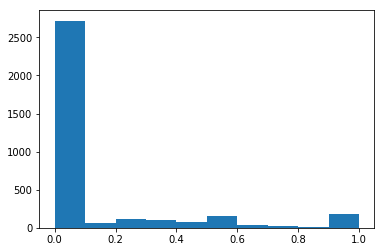

In [563]:
plt.hist(prot_dat.values[:,1])
plt.show()

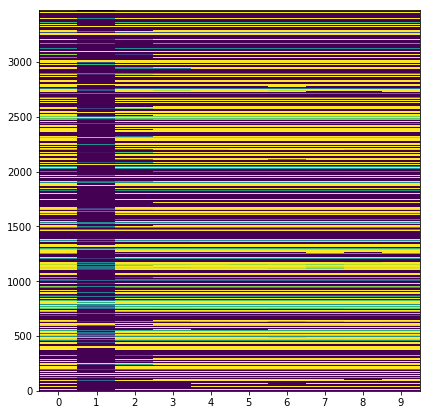

In [564]:
f, ax = plt.subplots()
ax.imshow(prot_dat.values, interpolation="nearest", aspect=10/prot_dat.shape[0], vmin=0)
ax.set_xticks(np.arange(0, 10, 1))
ax.set_xlim([-0.5, 9.5])
ax.set_ylim([0, prot_dat.shape[0]])

f.set_size_inches(7, 7)

plt.show()

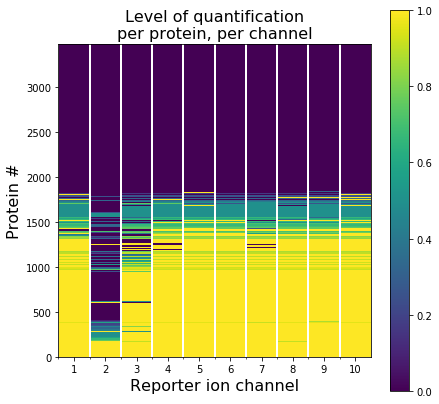

In [766]:
order = np.argsort(prot_dat.apply(np.sum, axis=1).values)[::-1]

#clust = hierarchy.fclusterdata(prot_dat, t=1.15)
#print(np.max(clust))
#order = np.argsort(clust)[::-1]

f, ax = plt.subplots()
mp = ax.imshow(prot_dat.values[order], interpolation="nearest", aspect=10/prot_dat.shape[0], vmin=0)
ax.set_xticks(np.arange(0, prot_dat.shape[1], 1))
ax.set_xticklabels(np.arange(1, prot_dat.shape[1]+1, 1))
ax.set_xlim([-0.5, prot_dat.shape[1]-0.5])
ax.set_ylim([0, prot_dat.shape[0]])

ax.set_xlabel("Reporter ion channel", fontsize=16)
ax.set_ylabel("Protein #", fontsize=16)
ax.set_title("Level of quantification\nper protein, per channel", fontsize=16)

ax.set_xticks(np.arange(-0.5, prot_dat.shape[1]-0.5, 1), minor=True);
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

plt.colorbar(mp, ax=ax)

f.set_size_inches(7, 7)
plt.show()

In [789]:
pep_thresh = 0.01
dcols = df.columns[df.columns.str.contains("Reporter intensity corrected")]
dfa = df.loc[~((df["Leading razor protein"].str.contains("CON__")) | (df["Leading razor protein"].str.contains("REV__")))]
dfa = dfa.loc[((dfa[dcols] != 0).apply(np.sum, axis=1) / len(dcols)) > 0.8]

dfa["Leading razor protein"] = dfa["Leading razor protein"].str.split("|").apply((lambda x: x[1] if len(x) == 3 else x[0]))

dfa_new = dfa.loc[dfa["pep_updated"] < pep_thresh]
dfa = dfa.loc[dfa["PEP"] < pep_thresh]

print(dfa.shape[0])
print(dfa_new.shape[0])

101160
185310


In [790]:
prots = pd.Series(np.sort(dfa_new["Leading razor protein"].unique()))
print(len(prots))

experiments = np.sort(dfa["Raw file"].unique())

dmat = np.zeros((len(prots), len(experiments)))
dmat_new = np.zeros((len(prots), len(experiments)))

for i, exp in enumerate(experiments):
    dfe = dfa.loc[dfa["Raw file"]==exp]
    dmat[prots.isin(dfe["Leading razor protein"]), i] = 1
    dfe = dfa_new.loc[dfa_new["Raw file"]==exp]
    dmat_new[prots.isin(dfe["Leading razor protein"]), i] = 1
    
dmat
dmat_new

experiments

3817


array(['180320S_QC_SQC65C1', '180320S_QC_SQC67A8', '180320S_QC_SQC67C8',
       '180320S_QC_SQC67E8', '180324S_QC_SQC67A9', '180324S_QC_SQC67C10',
       '180324S_QC_SQC67C11', '180324S_QC_SQC67C12',
       '180324S_QC_SQC67C13', '180324S_QC_SQC67C14',
       '180324S_QC_SQC67C15', '180324S_QC_SQC67C16',
       '180324S_QC_SQC67C17', '180324S_QC_SQC67C18', '180324S_QC_SQC67C9',
       '180324S_QC_SQC67E9', '180324S_QC_SQC69A', '180324S_QC_SQC69B',
       '180324S_QC_SQC69C', '180324S_QC_SQC69D', '180324S_QC_SQC69E',
       '180324S_QC_SQC69F', '180324S_QC_SQC69G', '180324S_QC_SQC70A',
       '180324S_QC_SQC70B', '180324S_QC_SQC70C',
       '180324S_QC_SQC70D_20180330082946', '180324S_QC_SQC70E',
       '180324S_QC_SQC71A', '180324S_QC_SQC71B', '180324S_QC_SQC71C',
       '180324S_QC_SQC71D', '180324S_QC_SQC71D2', '180324S_QC_SQC71E2',
       '180402S_QC_SQC72A1', '180402S_QC_SQC72A2', '180402S_QC_SQC72A3',
       '180402S_QC_SQC72A4', '180402S_QC_SQC72B1', '180402S_QC_SQC72B10',
      

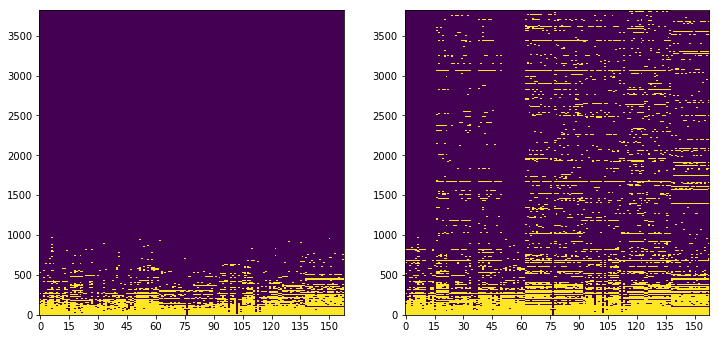

In [793]:
f, (ax1, ax2) = plt.subplots(1, 2)

order = np.argsort(np.apply_along_axis(np.sum, 1, dmat))[::-1]

mp1 = ax1.imshow(dmat[order], interpolation="nearest", aspect = dmat.shape[1] / dmat.shape[0], vmin=0)
ax1.set_xticks(np.arange(0, dmat.shape[1], np.floor(dmat.shape[1] / 10)))
#ax1.set_xticklabels(experiments, rotation=45, ha="right", rotation_mode="anchor")
#ax1.set_xticks(np.arange(0, dmat.shape[1], 1))
ax1.set_ylim([0, dmat.shape[0]])

mp2 = ax2.imshow(dmat_new[order], interpolation="nearest", aspect = dmat.shape[1] / dmat.shape[0], vmin=0)
ax2.set_xticks(np.arange(0, dmat.shape[1], np.floor(dmat.shape[1] / 10)))
ax2.set_ylim([0, dmat.shape[0]])

f.set_size_inches(12, 7)

plt.show()

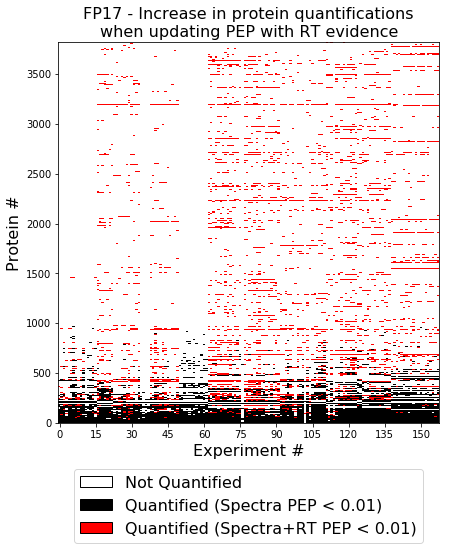

In [798]:
dmat_c = np.copy(dmat)
dmat_c[np.logical_and(np.logical_not(dmat), dmat_new)] = 2
#dmat_c

# Create the colormap
cm = LinearSegmentedColormap.from_list("a1", [(1, 1, 1), (0, 0, 0), (1, 0, 0)], N=3)

f, ax = plt.subplots()

#order = np.argsort(np.apply_along_axis(np.sum, 1, dmat_new))[::-1]
order = np.argsort(np.apply_along_axis(np.sum, 1, dmat))[::-1]

mp = ax.imshow(dmat_c[order], interpolation="nearest", aspect = dmat.shape[1] / dmat.shape[0], vmin=0, cmap=cm)
ax.set_xticks(np.arange(0, dmat.shape[1], np.floor(dmat.shape[1] / 10)))
#ax.set_xticklabels(experiments, rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylim([0, dmat.shape[0]])

ax.set_xlabel("Experiment #", fontsize=16)
ax.set_ylabel("Protein #", fontsize=16)
ax.set_title("FP17 - Increase in protein quantifications\nwhen updating PEP with RT evidence", fontsize=16)

ax.legend(handles=[mpatches.Patch(facecolor='white', edgecolor='black', label='Not Quantified'),
                   mpatches.Patch(facecolor='black', edgecolor='black', label='Quantified (Spectra PEP < 0.01)'),
                   mpatches.Patch(facecolor='red',   edgecolor='black', label='Quantified (Spectra+RT PEP < 0.01)')],
         loc="upper center",
         fancybox=True, #shadow=True,
         bbox_to_anchor=(0.5, -0.1),
         fontsize=16)

f.set_size_inches(7, 7)

plt.show()

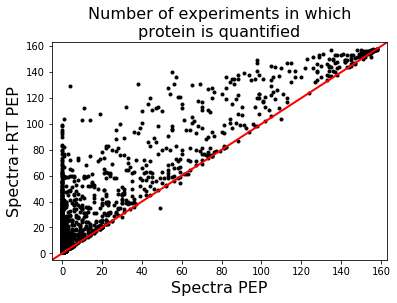

In [820]:
x = np.apply_along_axis(np.sum, 1, dmat)
y = np.apply_along_axis(np.sum, 1, dmat_new)

f, ax = plt.subplots()

ax.plot(x, y, '.k')
ax.plot([-100, 1000], [-100, 1000], '-r', linewidth=2)
ax.set_xlim([-5, dmat.shape[1]+5])
ax.set_ylim([-5, dmat.shape[1]+5])
ax.set_title("Number of experiments in which\nprotein is quantified", fontsize=16)
ax.set_xlabel("Spectra PEP", fontsize=16)
ax.set_ylabel("Spectra+RT PEP", fontsize=16)

plt.show()

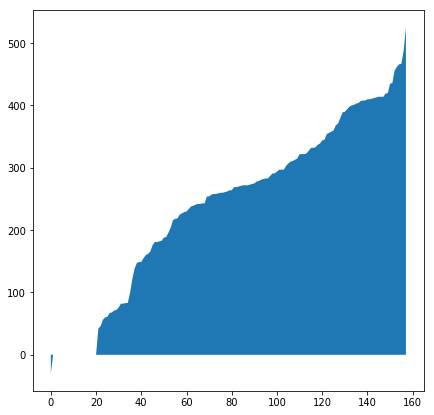

In [840]:
num = np.apply_along_axis(np.sum, 0, dmat)
num_new = np.apply_along_axis(np.sum, 0, dmat_new)
diff = np.apply_along_axis(np.sum, 0, dmat_new) - np.apply_along_axis(np.sum, 0, dmat)
np.argsort(diff)

x = np.arange(0, dmat.shape[1], 1)

f, ax = plt.subplots()

#ax.bar(x, np.sort(diff), color="red", width=0.8)
#ax.bar(x+0.3, num, color="blue", width=0.2)
#ax.bar(x+0.6, num_new, color="green", width=0.2)

#ax.plot(x, np.sort(diff), '-r')
ax.fill_between(x, np.sort(diff), 0)
#ax.plot(x, num, '-b')
#ax.plot(x, num_new, '-g')

#ax.set_xticks(x)
#ax.set_xticklabels(np.argsort(diff))
#ax.set_ylim([np.min(diff), np.max(num_new)])

f.set_size_inches(7, 7)

plt.show()